## Assignment 1: Perceptron Training
Neural Networks and Computational Intelligence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(29) # makes the random numbers predictable

In [2]:
## a) Generate artificial data sets
P = 5      # number of feature vectors 
N = 3      # dim of feature vectors

def datasets(N, P):
    D = np.zeros((N+1, P))       # empty data set (each column is a vector, last el. is the label)
    for mu in range(P):
        D[:-1, mu] = np.random.normal(0, 1, size=N)
        D[-1, mu] = np.random.randint(0, 2, size=1)        # the labels are 0 and 1 not -+1
        if D[-1, mu] == 0:
            D[-1, mu] = -1
    return D

D = datasets(N, P)
print(D)

[[-0.41748213 -2.1417555  -0.89422358  0.10193307  0.98494561]
 [ 0.7060321   0.23407402  0.80802964 -1.19332572 -1.1444064 ]
 [ 1.9159847   0.25027325 -0.20433129  0.00373976  0.38683645]
 [ 1.          1.          1.          1.         -1.        ]]


In [3]:
## b) Sequential perceptron training

n_max = 2     # max number of epochs (loops through D)
n = 1           # epoch counter
t = 0
while n <= n_max:
    print('epoch', n)
    for mu in range(P):
        print('mu('+str(t)+') = ', mu, ':', D[:-1, mu])
        t += 1 
    n += 1
print("Final t: ", t)

epoch 1
mu(0) =  0 : [-0.41748213  0.7060321   1.9159847 ]
mu(1) =  1 : [-2.1417555   0.23407402  0.25027325]
mu(2) =  2 : [-0.89422358  0.80802964 -0.20433129]
mu(3) =  3 : [ 0.10193307 -1.19332572  0.00373976]
mu(4) =  4 : [ 0.98494561 -1.1444064   0.38683645]
epoch 2
mu(5) =  0 : [-0.41748213  0.7060321   1.9159847 ]
mu(6) =  1 : [-2.1417555   0.23407402  0.25027325]
mu(7) =  2 : [-0.89422358  0.80802964 -0.20433129]
mu(8) =  3 : [ 0.10193307 -1.19332572  0.00373976]
mu(9) =  4 : [ 0.98494561 -1.1444064   0.38683645]
Final t:  10


In [4]:
## c) Rosenblatt algorithm
def Ros_alg(N, P, D, n_max, c_threshold=0, verbose=False):
    w = np.zeros(N)      # weight vector
    x = np.zeros(P) # embedding strengths
    E_mu = np.zeros(P)    # local potentials (one per input vector)
    n = 1
    #t = 0
    success = False
    while n <= n_max:
        #print('epoch', n)
        for mu in range(P):
            
            E_mu[mu] = np.dot(w, D[:-1, mu]) * D[-1, mu]
            
            heav = np.heaviside(c_threshold - E_mu[mu], 1) 
            
            if heav:
                w += 1/N * heav * D[:-1, mu] * D[-1, mu] 
                x[mu] += heav

        #t += 1
        if not np.any(E_mu <= 0):
            success = True
            break
        n += 1
        
    if verbose:
        print("Success: {} after {} out of {} max epochs".format(success, n, n_max))
        
    return w, x, n, success

n_max = 10
w, x, n, s = Ros_alg(N, P, D, n_max, verbose=True)

Success: True after 4 out of 10 max epochs


In [5]:
## Rosenblatt validation algorithm
def Ros_alg_theoretical(N, P, verbose=False):
    if P <= N:
        P_ls = 1
    else:
        P_ls = 0
        for ii in range(0, N):
            P_ls += np.math.factorial(P - 1) / (np.math.factorial(ii) * np.math.factorial(P - 1 - ii))
        P_ls *= 2**(1 - P)
        
    if verbose:
        print("P_ls of N = {}, P = {} -> {:.3f}".format(N, P, P_ls))
    
    return P_ls

a = Ros_alg_theoretical(N, P, verbose=True)

P_ls of N = 3, P = 5 -> 0.688


In [6]:
## d) Running the experiments  NOT PARALLEL
"""

def do_experiment_NP(alpha, N, n_D, n_max, c_threshold=0.0):
    P_ls = np.zeros((len(alpha), len(N)))
    P_ls_theoretical = np.zeros((len(alpha), len(N)))

    for aa in range(len(alpha)):
        print("It of alpha: {} out of {}".format(aa + 1, len(alpha)))
        for n_dim in N: 
            successful_runs = 0
            
            P = int(n_dim * alpha[aa])
            for dd in range(n_D):
                D = datasets(n_dim, P) # new generated dataset
                ww, xx, nn, ss = Ros_alg(n_dim, P, D, n_max, c_threshold=c_threshold)    #I think I dont need w for anything
                successful_runs += ss
                
            P_ls[aa, N.index(n_dim)] = successful_runs / n_D
            P_ls_theoretical[aa, N.index(n_dim)] = Ros_alg_theoretical(n_dim, P)
            
    return P_ls, P_ls_theoretical

#P_ls, P_ls_theoretical = do_experiment_NP(alpha, N_sizes, n_D, n_max, c_threshold=0.0)

"""

'\n\ndef do_experiment_NP(alpha, N, n_D, n_max, c_threshold=0.0):\n    P_ls = np.zeros((len(alpha), len(N)))\n    P_ls_theoretical = np.zeros((len(alpha), len(N)))\n\n    for aa in range(len(alpha)):\n        print("It of alpha: {} out of {}".format(aa + 1, len(alpha)))\n        for n_dim in N: \n            successful_runs = 0\n            \n            P = int(n_dim * alpha[aa])\n            for dd in range(n_D):\n                D = datasets(n_dim, P) # new generated dataset\n                ww, xx, nn, ss = Ros_alg(n_dim, P, D, n_max, c_threshold=c_threshold)    #I think I dont need w for anything\n                successful_runs += ss\n                \n            P_ls[aa, N.index(n_dim)] = successful_runs / n_D\n            P_ls_theoretical[aa, N.index(n_dim)] = Ros_alg_theoretical(n_dim, P)\n            \n    return P_ls, P_ls_theoretical\n\n#P_ls, P_ls_theoretical = do_experiment_NP(alpha, N_sizes, n_D, n_max, c_threshold=0.0)\n\n'

In [7]:
## Save and plot the results NOT PARALLEL

"""
def plot_save_results_NP(N_sizes, P_ls, P_ls_theoretical, name):
    out_folder = "Results/"
    with open(out_folder + "Pls_{}.npy".format(name), 'wb') as f:
        np.save(f, P_ls)
        np.save(f, P_ls_theoretical)

    plt.figure()
    colors = ["b", "r", "c", "g", "y", "m", "k"]
    for ii in range(len(N_sizes)):
        plt.plot(alpha, P_ls[:, ii], colors[ii]+"-", label="N = {}".format(N_sizes[ii]))
        plt.plot(alpha, P_ls_theoretical[:, ii], colors[ii]+"--")

    plt.xlabel('alpha = P/N')
    plt.ylabel('P_ls (Fraction of succesful runs)')
    plt.grid()
    plt.legend()
    plt.show()

#plot_save_results_NP(N_sizes, P_ls, P_ls_theoretical, "1")

"""

'\ndef plot_save_results_NP(N_sizes, P_ls, P_ls_theoretical, name):\n    out_folder = "Results/"\n    with open(out_folder + "Pls_{}.npy".format(name), \'wb\') as f:\n        np.save(f, P_ls)\n        np.save(f, P_ls_theoretical)\n\n    plt.figure()\n    colors = ["b", "r", "c", "g", "y", "m", "k"]\n    for ii in range(len(N_sizes)):\n        plt.plot(alpha, P_ls[:, ii], colors[ii]+"-", label="N = {}".format(N_sizes[ii]))\n        plt.plot(alpha, P_ls_theoretical[:, ii], colors[ii]+"--")\n\n    plt.xlabel(\'alpha = P/N\')\n    plt.ylabel(\'P_ls (Fraction of succesful runs)\')\n    plt.grid()\n    plt.legend()\n    plt.show()\n\n#plot_save_results_NP(N_sizes, P_ls, P_ls_theoretical, "1")\n\n'

In [18]:
## d) Running the experiments PARALLEL

def do_experiment(alpha, N, n_D, n_max, c_threshold=0.0, Theoretical = True):
    
    successful_runs = 0
    
    P = int(N * alpha)
    for dd in range(n_D):
        D = datasets(N, P) # new generated dataset
        ww, xx, nn, ss = Ros_alg(N, P, D, n_max, c_threshold=c_threshold)    #I think I dont need w for anything
        successful_runs += ss

        P_ls = successful_runs / n_D
        
    if Theoretical:
        P_ls_theoretical = Ros_alg_theoretical(N, P) 
                
        return P_ls, P_ls_theoretical, alpha, N
    else:
        return P_ls, alpha, N


In [36]:
## d) Running the experiments IN  PARALLEL
from joblib import Parallel, delayed
import pandas as pd

min_alpha = 0.75; max_alpha = 3; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))
N_sizes = [5, 20, 40]
n_D = 100 * 2   # number of random datasets for each P
n_max = 100 * 5     # max number of epochs 

def do_parallel(alpha, N, n_D, n_max, c_threshold=0.0, Theoretical = True,  n_jobs = 8):
    # This needs to have all the combinations
    parameters = []
    for n in N_sizes:
        for a in alpha:
            parameters.append([a, n])

    if Theoretical:
        results = pd.DataFrame(columns=['P_ls', 'P_ls_theoretical', 'alpha', 'N'])

    else:
        results = pd.DataFrame(columns=['P_ls', 'alpha', 'N'])


    res = (Parallel(n_jobs = 8)(delayed(do_experiment)(al, n, n_D, n_max, c_threshold, Theoretical) for  al, n in parameters))

    for i in res:
        results.loc[len(results)]=i
    return results

    
results = do_parallel(alpha, N_sizes, n_D, n_max)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


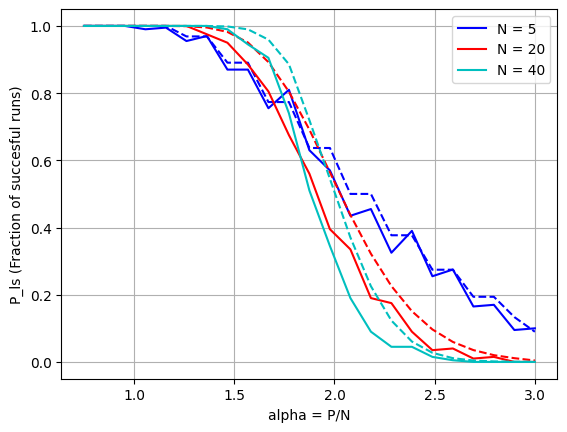

In [39]:
## Save and plot the results PARALLEL

def plot_save_results(results, name, Theoretical = True):
    out_folder = "Results/"
    with open(out_folder + "Pls_{}.npy".format(name), 'wb') as f:
        np.save(f, results)
        #np.save(f, P_ls_theoretical)

    plt.figure()
    colors = ["b", "r", "c", "g", "y", "m", "k"]
    for ii in range(len(N_sizes)):
        data = results.loc[results['N'] == N_sizes[ii]]
        if Theoretical:
            plt.plot(data['alpha'], data['P_ls'], colors[ii]+"-", label="N = {}".format(N_sizes[ii]))
            plt.plot(data['alpha'], data['P_ls_theoretical'], colors[ii]+"--")
        else:
            plt.plot(data['alpha'], data['P_ls'], colors[ii]+"-", label="N = {}".format(N_sizes[ii]))

    plt.xlabel('alpha = P/N')
    plt.ylabel('P_ls (Fraction of succesful runs)')
    plt.grid()
    plt.legend()
    plt.savefig("Results/Figures/Pls_{}.eps".format(name), format='eps')
    plt.savefig("Results/Figures/Pls_{}.png".format(name), format='png')
    plt.show()
plot_save_results(results, '1')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


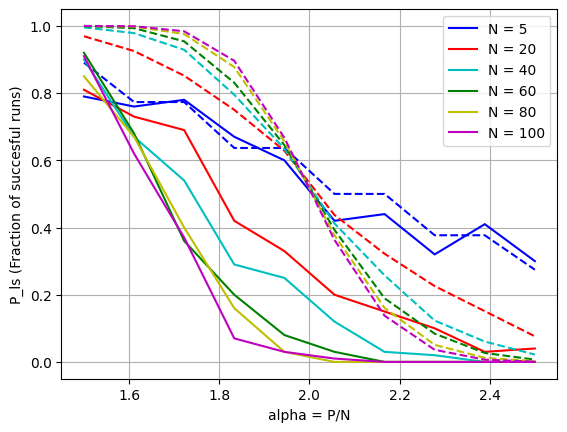

In [15]:
## Bonus: Observe the behavior of Q_ls for different system sizes N

min_alpha = 1.5; max_alpha = 2.5; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))

N_sizes = [5, 20, 40, 60, 80, 100]

n_D = 100   # number of random datasets for each P
n_max = 100     # max number of epochs 

Results = do_parallel(alpha, N_sizes, n_D, n_max)
plot_save_results(Results, "bonus1")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


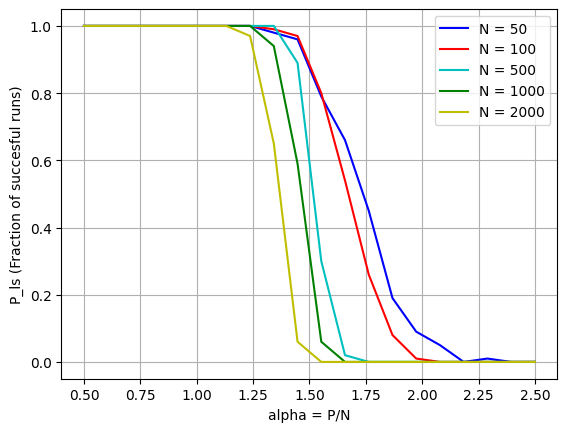

In [24]:
## Bonus: Observe the behavior of Q_ls for different system sizes N
"""takes forever to run"""

min_alpha = 0.5; max_alpha = 2.5; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))

N_sizes = [50, 100, 500, 1000, 2000]

n_D = 100   # number of random datasets for each P
n_max = 100     # max number of epochs 

#Results = do_parallel(alpha, N_sizes, n_D, n_max, Theoretical=False)
plot_save_results(Results, "bonus1_2", Theoretical = False)

In [23]:
Results

,P_ls,alpha,N
0,1.0,0.500000,50.0
1,1.0,0.605263,50.0
2,1.0,0.710526,50.0
3,1.0,0.815789,50.0
4,1.0,0.921053,50.0
...,...,...,...
95,0.0,2.078947,2000.0
96,0.0,2.184211,2000.0
97,0.0,2.289474,2000.0
98,0.0,2.394737,2000.0


In [29]:
## Bonus Embedding Strengths
P = 60
N = 30

n_D = 1  # you only do one experiment cause I doesnt make sense to sum xx from several
n_max = 100      # max number of epochs 

def do_experiment_emb(P, N, n_D, n_max, c_threshold=0.0):
    D = datasets(N, P) # new generated dataset
    ww, xx, nn, ss = Ros_alg(N, P, D, n_max, c_threshold=c_threshold)    #I think I dont need w for anything
    return xx

embedding_strengths= do_experiment_emb(P, N, n_D, n_max, c_threshold=0.0)



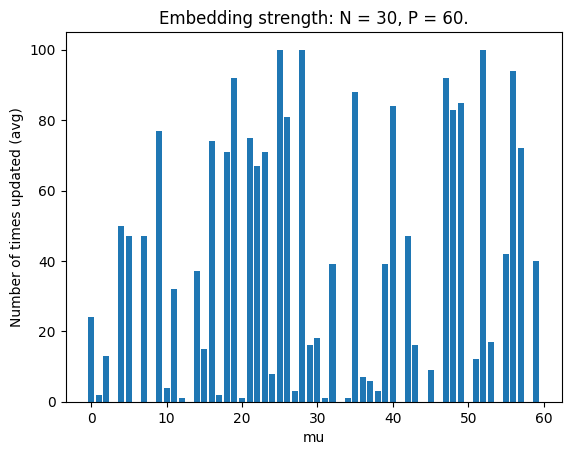

In [30]:
bins = np.arange(0, P, 1) 
plt.bar(bins, embedding_strengths)
plt.title("Embedding strength: N = {}, P = {}.".format(N,P))
plt.ylabel('Number of times updated (avg)')
plt.xlabel('mu')
plt.savefig("Results/Figures/Hist_embeddingS.eps", format='eps')
plt.savefig("Results/Figures/Hist_embeddingS.png", format='png')
plt.show()

# we need to comment that so many are not used

In [31]:
## Bonus: Consider a non-zero value of c

min_alpha = 0.75; max_alpha = 3; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))
N_sizes = [20]

n_D = 100*2   # number of random datasets for each P
n_max = 100*2     # max number of epochs
c_thresholds = [0, 0.1, 0.25, 0.5] 

results = pd.DataFrame(columns=['P_ls', 'P_ls_theoretical', 'alpha', 'N', 'c_thres'])


for cc in c_thresholds:
    c_thres = [cc for i in range(len(alpha)*len(N_sizes))]
    print("# C: {} out of {}".format(c_thresholds.index(cc) + 1, len(c_thresholds)))
    results_part = do_parallel(alpha, N_sizes, n_D, n_max, cc)
    results_part['c_thres'] = c_thres

    results = pd.concat([results, results_part])
    

# C: 1 out of 4
# C: 2 out of 4
# C: 3 out of 4
# C: 4 out of 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


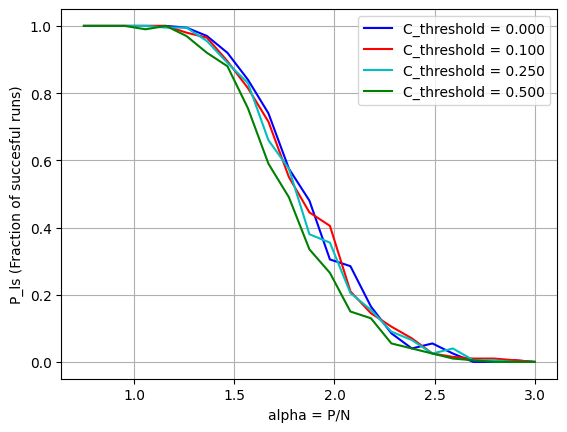

In [32]:
out_folder = "Results/"
with open(out_folder + "Pls_cthreshold.npy", 'wb') as f:
    for ii in range(len(c_thresholds)):
        #P_ls = results[ii]
        np.save(f, results)
        
colors = ["b", "r", "c", "g", "y", "m", "k"]
plt.figure()
for ii in range(len(c_thresholds)):
    
    # plt.subplot(1, 1, ii + 1) # considering now only 1 N
    data = results.loc[results['c_thres'] == c_thresholds[ii]]
    
    plt.plot(data['alpha'], data['P_ls'], colors[ii]+"-", label="C_threshold = {:.3f}".format(c_thresholds[ii]))

plt.xlabel('alpha = P/N')
plt.ylabel('P_ls (Fraction of succesful runs)')
plt.grid()
plt.legend()
plt.savefig("Results/Figures/Pls_cthreshold.eps", format='eps')
plt.savefig("Results/Figures/Pls_cthreshold.png", format='png')
plt.show()